In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import PCA

In [2]:
sentiments = pd.read_csv('./data/judge-1377884607_tweet_product_company.csv',encoding='ISO-8859-1')
sentiments.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [3]:
sentiments['product'] = sentiments['emotion_in_tweet_is_directed_at']
sentiments['sentiment'] = sentiments['is_there_an_emotion_directed_at_a_brand_or_product']

sentiments.drop(axis=1, columns=['emotion_in_tweet_is_directed_at','is_there_an_emotion_directed_at_a_brand_or_product'], inplace=True)

In [4]:
sentiments['sentiment'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [5]:
sentiments['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

In [6]:
sentiments.dropna(subset=['tweet_text'],inplace=True)

In [67]:
tokenizer = RegexpTokenizer(r"([@#]?[a-zA-Z]+(?:’[a-z]+)?)")

stopwords_list = stopwords.words('english')

specific_words = ['@mention','link','sxsw','#sxsw','@sxsw']

stopwords_list.extend(specific_words)

lemmer = WordNetLemmatizer()

In [69]:
def preprocess_text(text, tokenizer, stopwords_list, stemmer):
    # Standardize case (lowercase the text)
    lower_t = text.lower()
    
    # Tokenize text using `tokenizer`
    tokens = tokenizer.tokenize(lower_t)
    
    # Remove stopwords using `stopwords_list`
    stopped_tokens = [token for token in tokens if token not in stopwords_list]
    
    # Stem the tokenized text using `stemmer`
    lems = [lemmer.lemmatize(token) for token in stopped_tokens]
    
    
    # Return the preprocessed text
    return lems
preprocess_text("This is an @example #sxsw #sentence for preprocessing.", tokenizer, stopwords_list, stemmer)

['@example', '#sentence', 'preprocessing']

In [ ]:
def preprocess_text(text, tokenizer, stopwords_list, stemmer):
    # Standardize case (lowercase the text)
    lower_t = text.lower()
    
    # Tokenize text using `tokenizer`
    tokens = tokenizer.tokenize(lower_t)
    
    # Remove stopwords using `stopwords_list`
    stopped_tokens = [token for token in tokens if token not in stopwords_list]
    
    # Stem the tokenized text using `stemmer`
    lems = [lemmer.lemmatize(token) for token in stopped_tokens]
    
    
    # Return the preprocessed text
    return lems

data1 = sentiments.copy()


text_data = data1.tweet_text.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))
text_data

In [70]:
data1 = sentiments.copy()

In [71]:
text_data = data1.tweet_text.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))
text_data

0       [@wesley, g, iphone, hr, tweeting, #rise, aust...
1       [@jessedee, know, @fludapp, awesome, ipad, iph...
2                  [@swonderlin, wait, #ipad, also, sale]
3       [hope, year, festival, crashy, year, iphone, app]
4       [@sxtxstate, great, stuff, fri, marissa, mayer...
                              ...                        
9088                                   [ipad, everywhere]
9089    [wave, buzz, rt, interrupt, regularly, schedul...
9090    [google, zeiger, physician, never, reported, p...
9091    [verizon, iphone, customer, complained, time, ...
9092                     [rt, google, test, check, offer]
Name: tweet_text, Length: 9092, dtype: object

In [72]:
data["preprocessed_text"] = text_data
data

,tweet_text,product,sentiment,preprocessed_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[@wesley, g, iphone, hr, tweeting, #rise, aust..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[@jessedee, know, @fludapp, awesome, ipad, iph..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[@swonderlin, wait, #ipad, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[hope, year, festival, crashy, year, iphone, app]"
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[@sxtxstate, great, stuff, fri, marissa, mayer..."
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,"[ipad, everywhere]"
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,"[wave, buzz, rt, interrupt, regularly, schedul..."
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,"[google, zeiger, physician, never, reported, p..."
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,"[verizon, iphone, customer, complained, time, ..."


In [21]:
def tokenized(text):
    tokenizer_ = RegexpTokenizer(r"([@#]?[a-zA-Z]+(?:’[a-z]+)?)")
    sw = stopwords.words('english')
    text = [str(phrase).lower() for phrase in text]
    tokens = [' '.join(tokenizer_.tokenize(str(doc))) for doc in text]
    stems = [stemmer.lemmatize(token) for token in tokens]
    return stems

In [15]:
vect = pd.DataFrame(X.toarray(),columns=tfidf.get_feature_names())
vect.head()

,ab,able,able to,able to afford,able to afford to,about,about apple,about apple pop,about apple pop up,about google,...,your sxsw,yourmom,yourself,youtube,yr,zappos,zazzlesxsw,zazzlesxsw sxsw,zlf,zomb
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.145596,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tokenizer = RegexpTokenizer('\w{3,}')

# Create a list of stopwords in English
stopwords_list = stopwords.words('english')

In [23]:
text_data = sentiments.desc.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))
data["preprocessed_text"] = text_data
data

AttributeError: 'DataFrame' object has no attribute 'desc'

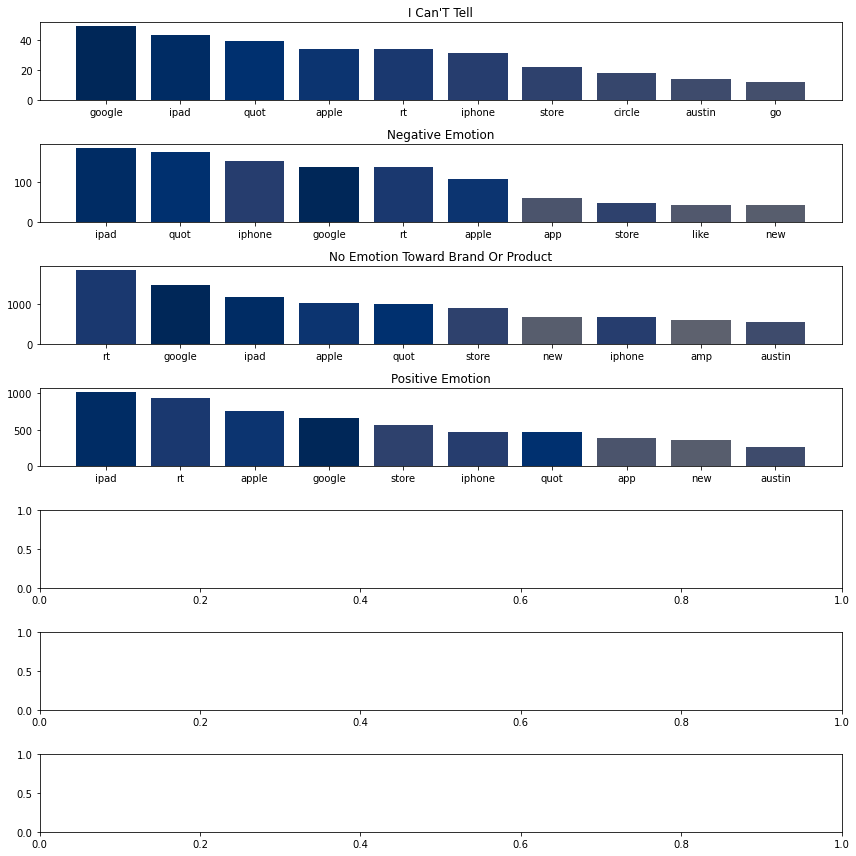

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up figure and axes
fig, axes = plt.subplots(nrows=7, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
# (If you get an error message about popping from an empty list, increase this #)
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each unique sentiment
data_by_sentiment = [y for _, y in data.groupby('sentiment', as_index=False)]
for idx, sentiment_df in enumerate(data_by_sentiment):
    # Find top 10 words in this genre
    all_words_in_tweet = sentiment_df.preprocessed_text.explode()
    top_10 = all_words_in_tweet.value_counts()[:10]
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(sentiment_df.iloc[0].sentiment.title())
    
fig.tight_layout()

In [62]:
sw1 = stopwords.words('english')
specific_words = ['@mention','link','sxsw','#sxsw','@sxsw']
sw1.extend(specific_words)
sw1

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [63]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from nltk.stem import WordNetLemmatizer

def preprocess(texts,sw=None):
    if sw==None:
        sw = sw1.copy()
    # make texts lowercase
    texts = [str(phrase).lower() for phrase in texts]
    clean_texts = []
    for text in texts:
        tokens_ = text.split(' ')
        clean_texts.append([token for token in tokens_ if token not in sw])
    tokenizer_ = RegexpTokenizer(r"([@#]?[a-zA-Z]+(?:’[a-z]+)?)")
    tokens = [' '.join(tokenizer_.tokenize(str(doc))) for doc in clean_texts]
    lemmer = WordNetLemmatizer()
    full_cleaned = [lemmer.lemmatize(token) for token in tokens]
    return full_cleaned

In [64]:
preprocess(sentiments['tweet_text'])

['@wesley g iphone hrs tweeting #rise austin dead need upgrade plugin stations #sxsw',
 '@jessedee know @fludapp awesome ipad iphone app likely appreciate design also they re giving free ts #sxsw',
 '@swonderlin wait #ipad also sale #sxsw',
 '@sxsw hope year s festival crashy year s iphone app #sxsw',
 '@sxtxstate great stuff fri #sxsw marissa mayer google tim o reilly tech books conferences amp matt mullenweg wordpress',
 '@teachntech new ipad apps #speechtherapy communication showcased #sxsw conference http ht ly n m #iear #edchat #asd',
 '#sxsw starting #ctia around corner #googleio hop skip jump there good time #android fan',
 'beautifully smart simple idea rt @madebymany @thenextweb wrote #hollergram ipad app #sxsw http bit ly ieavob',
 'counting days #sxsw plus strong canadian dollar means stock apple gear',
 'excited meet @samsungmobileus #sxsw show sprint galaxy still running android #fail',
 'find amp start impromptu parties #sxsw @hurricaneparty http bit ly gvlrin can t wait 

In [65]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from nltk.stem import WordNetLemmatizer

def preprocess(texts,sw=None):
    if sw==None:
        sw = stopwords.words('english')
        specific_words = ['link','@sxsw']
        sw.extend(specific_words)

    # make texts lowercase
    texts = [str(phrase).lower() for phrase in texts]
    clean_texts = []
    for text in texts:
        tokens_ = text.split(' ')
        clean_texts.append([token for token in tokens_ if token not in sw])
    tokenizer_ = RegexpTokenizer(r"([@#]?[a-zA-Z]+(?:’[a-z]+)?)")
    tokens = [' '.join(tokenizer_.tokenize(str(doc))) for doc in clean_texts]
    lemmer = WordNetLemmatizer()
    full_cleaned = [lemmer.lemmatize(token) for token in tokens]
    return full_cleaned


preprocess(sentiments['tweet_text'])

['@wesley g iphone hrs tweeting #rise austin dead need upgrade plugin stations #sxsw',
 '@jessedee know @fludapp awesome ipad iphone app likely appreciate design also they re giving free ts #sxsw',
 '@swonderlin wait #ipad also sale #sxsw',
 'hope year s festival crashy year s iphone app #sxsw',
 '@sxtxstate great stuff fri #sxsw marissa mayer google tim o reilly tech books conferences amp matt mullenweg wordpress',
 '@teachntech new ipad apps #speechtherapy communication showcased #sxsw conference http ht ly n m #iear #edchat #asd',
 '#sxsw starting #ctia around corner #googleio hop skip jump there good time #android fan',
 'beautifully smart simple idea rt @madebymany @thenextweb wrote #hollergram ipad app #sxsw http bit ly ieavob',
 'counting days #sxsw plus strong canadian dollar means stock apple gear',
 'excited meet @samsungmobileus #sxsw show sprint galaxy still running android #fail',
 'find amp start impromptu parties #sxsw @hurricaneparty http bit ly gvlrin can t wait til an

In [75]:
def preprocess_text(texts,sw=None):
    if sw==None:
        sw = stopwords.words('english')
    # specific_words = ['@mention','link','sxsw','#sxsw','@sxsw']
    # sw.extend(specific_words)
    # make texts lowercase
    texts = [str(phrase).lower() for phrase in texts]

    tokenizer_ = RegexpTokenizer(r"([@#]?[a-zA-Z]+(?:’[a-z]+)?)")
    tokens = [' '.join(tokenizer_.tokenize(str(doc))) for doc in texts]

    # print(tokens)

    clean_texts = []
    for token in tokens:
        # split texts into individual tokens
        tokens_ = token.split(' ')
        # append an array of tokens to clean_texts if they are not in stop words
        nsw = [token_ for token_ in tokens_ if token_ not in sw]
        clean_texts.append(nsw)
    # print(clean_texts[0])
    lemmer = WordNetLemmatizer()
    full_cleaned = [
        ' '.join([lemmer.lemmatize(word) for word in token])
        for token in clean_texts
    ]
    # for text in clean_texts:
    #     full_cleaned.append([lemmer.lemmatize(token) for token in token])
    return full_cleaned

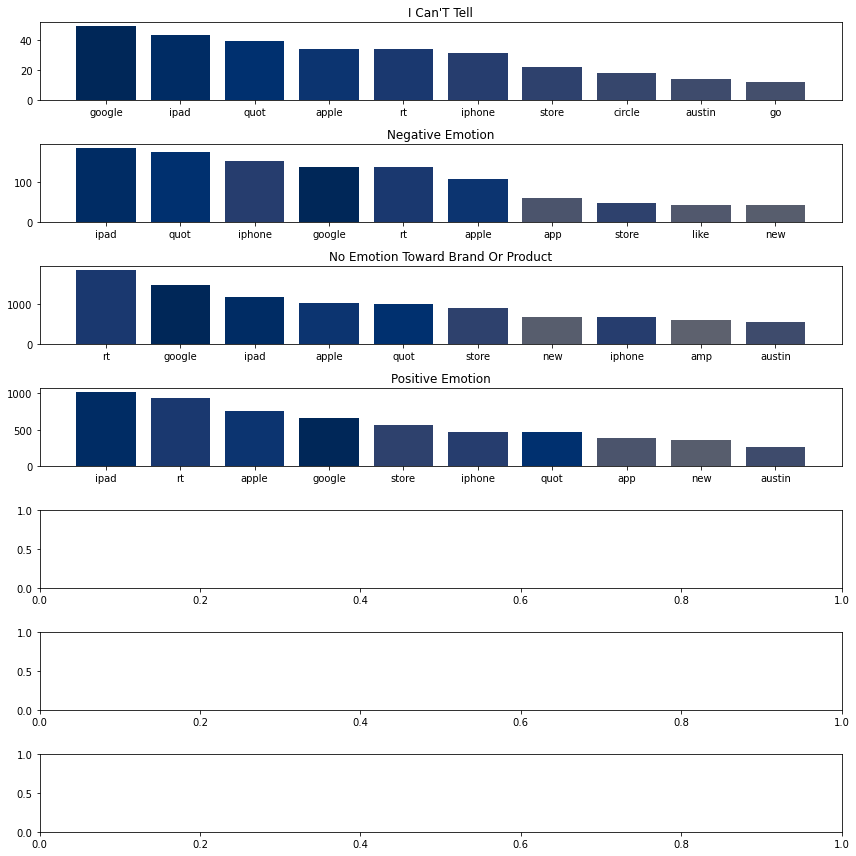

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up figure and axes
fig, axes = plt.subplots(nrows=7, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
# (If you get an error message about popping from an empty list, increase this #)
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each unique sentiment
data_by_sentiment = [y for _, y in data.groupby('sentiment', as_index=False)]
for idx, sentiment_df in enumerate(data_by_sentiment):
    # Find top 10 words in this genre
    all_words_in_tweet = sentiment_df.preprocessed_text.explode()
    top_10 = all_words_in_tweet.value_counts()[:10]
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(sentiment_df.iloc[0].sentiment.title())
    
fig.tight_layout()